# 1. Environment


In [ ]:
!pip -q install transformers datasets evaluate accelerate scikit-learn gradio

In [7]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import evaluate
import gradio as gr
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModelForMaskedLM,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    DataCollatorForLanguageModeling
)
from sklearn.utils.class_weight import compute_class_weight

# 2. load data & data preprocessing


In [8]:
ds = load_dataset("TheFinAI/fiqa-sentiment-classification")

def score_to_label(example, thr=0.2):
    s = float(example["score"])
    if s >= thr: label = 2     # Positive
    elif s <= -thr: label = 0  # Negative
    else: label = 1            # Neutral
    example["label"] = label
    return example

ds = ds.map(score_to_label)
model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize_fn(batch):
    return tokenizer(batch["sentence"], truncation=True, max_length=128)

tokenized_ds = ds.map(tokenize_fn, batched=True)
train_tok = tokenized_ds["train"]
val_tok = tokenized_ds["valid"]
test_tok = tokenized_ds["test"]

Map:   0%|          | 0/822 [00:00<?, ? examples/s]

Map:   0%|          | 0/234 [00:00<?, ? examples/s]

Map:   0%|          | 0/117 [00:00<?, ? examples/s]

Map:   0%|          | 0/822 [00:00<?, ? examples/s]

Map:   0%|          | 0/234 [00:00<?, ? examples/s]

Map:   0%|          | 0/117 [00:00<?, ? examples/s]

# 3. TAPT (Task-Adaptive Pretraining)


In [9]:
mlm_texts = Dataset.from_dict({"text": ds["train"]["sentence"]})
mlm_ds = mlm_texts.train_test_split(test_size=0.1, seed=42)

def tok_mlm(batch):
    return tokenizer(batch["text"], truncation=True, max_length=128)

mlm_train = mlm_ds["train"].map(tok_mlm, batched=True, remove_columns=["text"])
mlm_val = mlm_ds["test"].map(tok_mlm, batched=True, remove_columns=["text"])

mlm_model = AutoModelForMaskedLM.from_pretrained(model_ckpt)
mlm_args = TrainingArguments(
    output_dir="tapt_weights",
    eval_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="no",
    report_to="none"
)

mlm_trainer = Trainer(
    model=mlm_model,
    args=mlm_args,
    train_dataset=mlm_train,
    eval_dataset=mlm_val,
    data_collator=DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15),
)

print(">>> Starting TAPT...")
mlm_trainer.train()
mlm_trainer.save_model("fin_bert_tapt")


Map:   0%|          | 0/739 [00:00<?, ? examples/s]

Map:   0%|          | 0/83 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/202 [00:00<?, ?it/s]

BertForMaskedLM LOAD REPORT from: bert-base-uncased
Key                         | Status     |  | 
----------------------------+------------+--+-
bert.pooler.dense.bias      | UNEXPECTED |  | 
bert.pooler.dense.weight    | UNEXPECTED |  | 
cls.seq_relationship.weight | UNEXPECTED |  | 
cls.seq_relationship.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


>>> Starting TAPT...


Epoch,Training Loss,Validation Loss
1,No log,4.135684
2,No log,3.812708
3,No log,3.525577


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

# 4. TAPT Calibrated Fine-tuning
## core：Label Smoothing

In [10]:
# calculate weight (deal with inbalanced data)
y_train = np.array(train_tok["label"])
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
weights = torch.tensor(class_weights, dtype=torch.float).to("cuda" if torch.cuda.is_available() else "cpu")



class CalibratedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # introduce Label Smoothing
        loss_fct = nn.CrossEntropyLoss(
            weight=weights,
            label_smoothing=0.1
        )

        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

acc_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": acc_metric.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro": f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"],
    }

# reload TAPT weight for Calibrated Fine-tuning
final_model = AutoModelForSequenceClassification.from_pretrained("fin_bert_tapt", num_labels=3)

finetune_args = TrainingArguments(
    output_dir="calibrated_classifier",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    num_train_epochs=7,
    warmup_ratio=0.15,
    weight_decay=0.06,
    seed=42,
    report_to="none"
)

trainer = CalibratedTrainer(
    model=final_model,
    args=finetune_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

print(">>> Starting Calibrated Fine-tuning with Label Smoothing...")
trainer.train()


Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: fin_bert_tapt
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
bert.pooler.dense.weight                   | MISSING    | 
bert.pooler.dense.bias                     | MISSING    | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
warmup_ratio is deprecated and will be re

>>> Starting Calibrated Fine-tuning with Label Smoothing...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,1.077981,0.341880,0.327614
2,No log,1.043955,0.572650,0.494845
3,No log,0.891039,0.632479,0.596667
4,No log,0.804267,0.726496,0.678013
5,No log,0.765420,0.743590,0.688478
6,No log,0.783300,0.709402,0.664141
7,No log,0.764439,0.752137,0.701837


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

TrainOutput(global_step=364, training_loss=0.8304669726025927, metrics={'train_runtime': 348.4832, 'train_samples_per_second': 16.512, 'train_steps_per_second': 1.045, 'total_flos': 127681952673240.0, 'train_loss': 0.8304669726025927, 'epoch': 7.0})

# 5. Product-based interaction (Gradio Demo)


In [11]:
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}

def predict_service(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True).to(final_model.device)
    with torch.no_grad():
        outputs = final_model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1).cpu().numpy()[0]

    idx = np.argmax(probs)
    # calculate confidence level & Margin
    conf = float(probs[idx])
    sorted_p = sorted(probs, reverse=True)
    margin = sorted_p[0] - sorted_p[1]

    is_borderline = margin < 0.15 or conf < 0.6
    status = "Borderline - Review Needed" if is_borderline else "High Confidence"

    res_dict = {label_map[i]: float(probs[i]) for i in range(3)}
    report = f"**Decision**: {label_map[idx]} | **Status**: {status} (Margin: {margin:.2f})"
    return res_dict, report

demo = gr.Interface(
    fn=predict_service,
    inputs=gr.Textbox(label="Financial News Input"),
    outputs=[gr.Label(label="Sentiment Distribution"), gr.Markdown(label="Analysis")],
    title="Fin-Intelligence TAPT Classifier",
    examples=[
        ["The company filed for bankruptcy after a catastrophic fraud investigation."],
        ["NVIDIA reports record-breaking revenue fueled by massive AI infrastructure spending."],
        ["Following the completion of the merger, the new entity will be headquartered in Singapore."],
        ["The tech giant reported a 10% increase in quarterly revenue, but warned that global supply chain disruptions could significantly impact profit margins in the coming months."]
    ]
)

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c1c4635a7cc4df78bd.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# 6. Baseline Training (Standard BERT)


In [12]:
print(">>> Starting Baseline BERT Training (No TAPT, No Weights)...")

baseline_model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=3)

baseline_args = TrainingArguments(
    output_dir="baseline_classifier",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    learning_rate=2e-5, # Standard learning rate
    per_device_train_batch_size=16,
    num_train_epochs=4,
    seed=42,
    report_to="none"
)

# Using standard Trainer (No Weighted Loss)
baseline_trainer = Trainer(
    model=baseline_model,
    args=baseline_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

baseline_trainer.train()
baseline_results = baseline_trainer.evaluate(test_tok)
tapt_results = trainer.evaluate(test_tok)

>>> Starting Baseline BERT Training (No TAPT, No Weights)...


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.981269,0.512821,0.225989
2,No log,0.941534,0.529915,0.296022
3,No log,0.748593,0.675214,0.622684
4,No log,0.730423,0.700855,0.620299


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

# 7. Quantitative Error Analysis


In [13]:
def get_predictions(model, dataset):
    model.eval()
    all_preds = []
    all_probs = []

    # Simple batching for inference
    for i in range(0, len(dataset), 32):
        batch = dataset[i : i+32]
        inputs = tokenizer(batch["sentence"], return_tensors="pt", padding=True, truncation=True).to(model.device)
        with torch.no_grad():
            logits = model(**inputs).logits
            probs = torch.softmax(logits, dim=-1).cpu().numpy()
            all_preds.extend(np.argmax(probs, axis=-1))
            all_probs.extend(probs)
    return np.array(all_preds), np.array(all_probs)

print(">>> Analyzing Predictions...")
base_preds, _ = get_predictions(baseline_model, test_tok)
tapt_preds, _ = get_predictions(final_model, test_tok)
true_labels = np.array(test_tok["label"])

# Find cases where TAPT won
improved_idx = np.where((base_preds != true_labels) & (tapt_preds == true_labels))[0]

analysis_df = pd.DataFrame({
    "Sentence": [test_tok[int(i)]["sentence"] for i in improved_idx],
    "Ground_Truth": [label_map[true_labels[int(i)]] for i in improved_idx],
    "Baseline_Wrong": [label_map[base_preds[int(i)]] for i in improved_idx]
})

print("\n--- Improvement Analysis ---")
print(f"Number of samples Baseline missed but TAPT corrected: {len(improved_idx)}")
print("\nSamples of TAPT Success Over Baseline:")
display(analysis_df.head(20))

>>> Analyzing Predictions...

--- Improvement Analysis ---
Number of samples Baseline missed but TAPT corrected: 23

Samples of TAPT Success Over Baseline:


,Sentence,Ground_Truth,Baseline_Wrong
0,"FTSE led lower by M&S, GlaxoSmithKline",Negative,Positive
1,Diageo Sells Ryder Cup Venue Gleneagles Hotel ...,Neutral,Positive
2,US sanctions put Gazprom-Shell alliance plans ...,Negative,Neutral
3,UPDATE 1-BHP Billiton's credit ratings fragile...,Negative,Neutral
4,Renewed AB InBev Bid for SABMiller Ups Stake i...,Positive,Neutral
5,CompaniesAB InBev signals it won't go hostile ...,Neutral,Negative
6,AstraZeneca diabetes drug combination faces de...,Negative,Neutral
7,AB InBev offers SABMiller $3 billion breakup fee,Neutral,Positive
8,Britain's FTSE forges ahead as Shire surges,Positive,Neutral
9,AB InBev attacks SABMiller bid rebuffal,Neutral,Negative


# 8. Visual Comparison (Confusion Matrices)


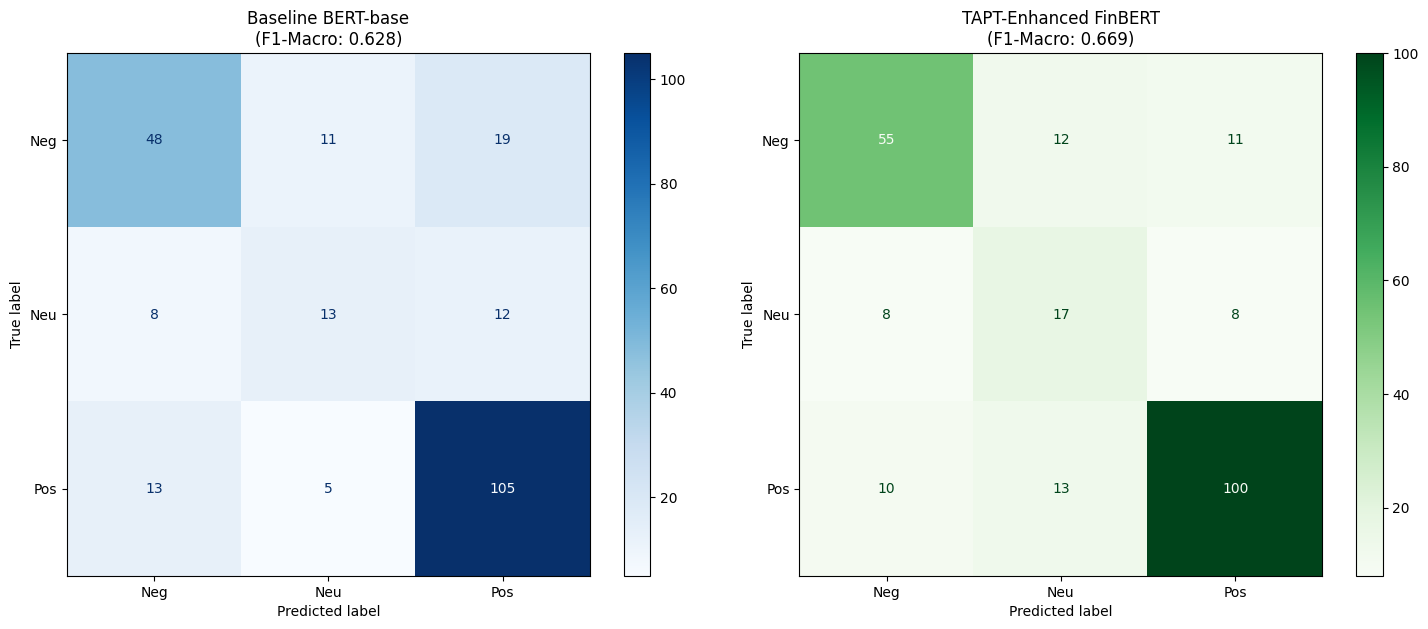


Final Performance Comparison Table:
  Metric  Baseline BERT  TAPT FinBERT
Accuracy       0.709402      0.735043
F1-Macro       0.627742      0.669419
    Loss       0.759395      0.846563


In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Baseline CM
cm_base = confusion_matrix(true_labels, base_preds)
disp_base = ConfusionMatrixDisplay(cm_base, display_labels=["Neg", "Neu", "Pos"])
disp_base.plot(cmap="Blues", ax=ax[0], values_format='d')
ax[0].set_title(f"Baseline BERT-base\n(F1-Macro: {baseline_results['eval_f1_macro']:.3f})")

# TAPT CM
cm_tapt = confusion_matrix(true_labels, tapt_preds)
disp_tapt = ConfusionMatrixDisplay(cm_tapt, display_labels=["Neg", "Neu", "Pos"])
disp_tapt.plot(cmap="Greens", ax=ax[1], values_format='d')
ax[1].set_title(f"TAPT-Enhanced FinBERT\n(F1-Macro: {tapt_results['eval_f1_macro']:.3f})")

plt.tight_layout()
plt.show()

# Final Summary Table
comparison_data = {
    "Metric": ["Accuracy", "F1-Macro", "Loss"],
    "Baseline BERT": [baseline_results['eval_accuracy'], baseline_results['eval_f1_macro'], baseline_results['eval_loss']],
    "TAPT FinBERT": [tapt_results['eval_accuracy'], tapt_results['eval_f1_macro'], tapt_results['eval_loss']]
}
print("\nFinal Performance Comparison Table:")
print(pd.DataFrame(comparison_data).to_string(index=False))

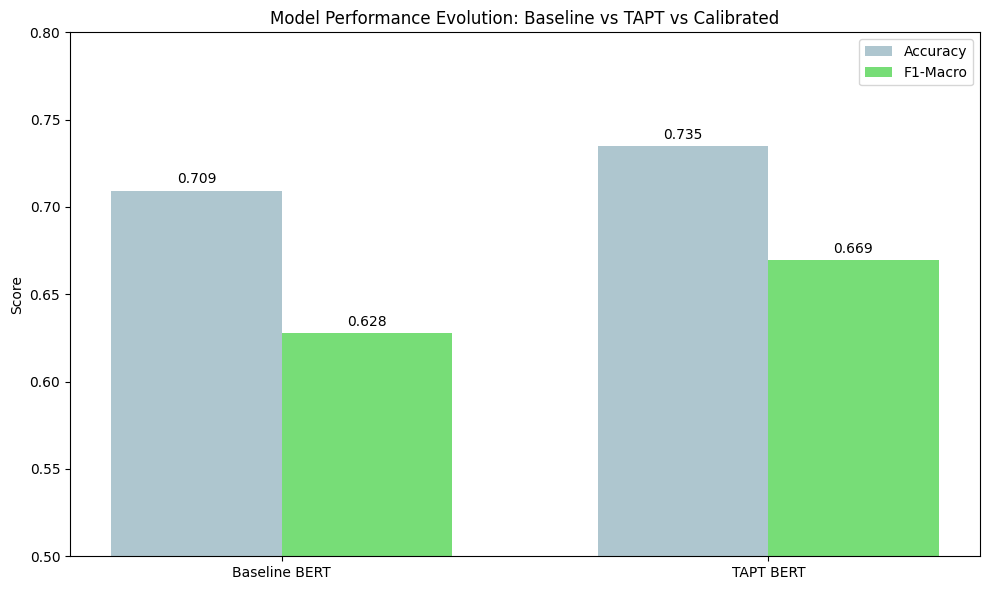

In [16]:
import matplotlib.pyplot as plt
import pandas as pd


data = {
    "Model": ["Baseline BERT", "TAPT BERT"],
    "Accuracy": [0.7094, 0.7350],
    "F1-Macro": [0.6277, 0.6694]
}

df_plot = pd.DataFrame(data)

plt.style.use('seaborn-v0_8-muted')
fig, ax1 = plt.subplots(figsize=(10, 6))

x = np.arange(len(df_plot["Model"]))
width = 0.35

rects1 = ax1.bar(x - width/2, df_plot["Accuracy"], width, label='Accuracy', color='#AEC6CF')
rects2 = ax1.bar(x + width/2, df_plot["F1-Macro"], width, label='F1-Macro', color='#77DD77')

ax1.set_ylabel('Score')
ax1.set_title('Model Performance Evolution: Baseline vs TAPT vs Calibrated')
ax1.set_xticks(x)
ax1.set_xticklabels(df_plot["Model"])
ax1.set_ylim(0.5, 0.8)
ax1.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax1.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()